# Chapter 10. Introduction to ANN with Keras

## Implementing MLPs with Keras

In [1]:
import tensorflow as tf
from tensorflow import keras

print('tensorflow:', tf.__version__)
print('keras:', keras.__version__)

tensorflow: 2.0.0-beta1
keras: 2.2.4-tf


Keras provides some utility functions to fetch and load common datasets, including MNIST, Fashion MNIST, and the California housing dataset.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Note that the dataset is already split into a training set and a test set, but there is no validation set, so we'll create one now.

We are going to train the network using Gradient Descent, we must scale the input features. We'll scale the pixel intensities down to the 0-1 range.

In [3]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

Here we create a `Sequential` model.

- The first layer is a `Flatten` layer, whose role is to convert each input image into a 1D array: if it receives input data `X`, it computes `X.reshape(-1, 1)`.
- Next we add a `Dense` hidden layer, with 300 neurons, using the ReLU activation function. Each `Dense` layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms, one per neuron. When it receives some input data, it computes
    $$
        h_{W,b}(X) = \phi(XW+b).
    $$
- Then we add a second `Dense` hidden layer, with 100 neurons, using the ReLU activation function.
- Finally, we add a `Dense` output layer, with 10 neurons, one per class, using the softmax activation function because the classes are *exclusive*.

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation=keras.activations.relu),
    keras.layers.Dense(100, activation=keras.activations.relu),
    keras.layers.Dense(10, activation=keras.activations.softmax),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Note that `Dense` layers often have a lot of parameters. For example, the first hidden layer has $784 \times 300$ connection weights, plus $300$ bias terms, which adds up to $235,500$ parameters. This gives the model quite a lot of flexibility to fit the training data, but also means that the model runs the risk of *overfitting*.

All the parameters of a layer can be accessed using its `get_weights()` and `set_weights()` methods. For a `Dense` layer, this includes both the connection weights and the bias terms.

Notice that the Dense layer initialized the connection weights randomly (which is needed to break symmetry), and the biases were initialized to zeros, which is fine. If you ever want to use a different initialization method, you can set `kernel_initializer` (*kernel* is another name for the matrix of connection weights) or `bias_initializer` when creating the layer.

In [5]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()

After a model is created, you must call its `compile()` method to specify the loss function and the optimizer to use. Optionally, you can specify a list of extra metrics to compute during training and evaluation.

We'll use many other [losses](https://keras.io/losses), [optimizers](https://keras.io/optimizers), and [metrics](https://keras.io/metrics) later.

Here we use the `sparse_categorical_crossentropy` loss because we have sparse labels, and the classes are exclusive.

In [6]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])

Now the model is ready to be trained.

In [7]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.7032 - sparse_categorical_accuracy: 0.7698 - val_loss: 0.4958 - val_sparse_categorical_accuracy: 0.8368
Epoch 2/30
55000/55000 [==============================] - 2s 31us/sample - loss: 0.4879 - sparse_categorical_accuracy: 0.8300 - val_loss: 0.4395 - val_sparse_categorical_accuracy: 0.8508
Epoch 3/30
55000/55000 [==============================] - 2s 31us/sample - loss: 0.4440 - sparse_categorical_accuracy: 0.8449 - val_loss: 0.4251 - val_sparse_categorical_accuracy: 0.8530
Epoch 4/30
55000/55000 [==============================] - 2s 31us/sample - loss: 0.4165 - sparse_categorical_accuracy: 0.8549 - val_loss: 0.3967 - val_sparse_categorical_accuracy: 0.8650
Epoch 5/30
55000/55000 [==============================] - 2s 31us/sample - loss: 0.3962 - sparse_categorical_

The `fit()` method returns a `History` object containing

- the training parameters (`history.params`),
- the list of epochs it went through (`history.epoch`), and most importantly
- a dictionary (`history.history`) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set (if any).

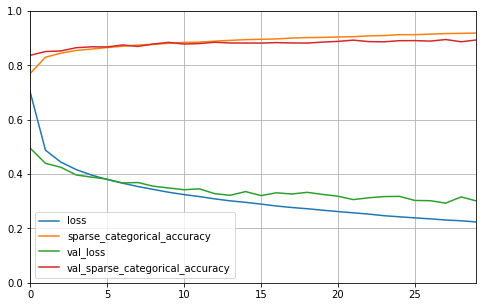

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

You can see that both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease.

If you are not satisfied with the performance of your model, you should go back and tune the *hyperparameters*.

- learning rate
- optimizer
- the number of layers, neurons per layer, types of activation functions
- batch size

Once you are satisifed with your model's validation accuracy, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production. You can easily do this using the `evaluate()` method.

In [9]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 19us/sample - loss: 2.2580 - sparse_categorical_accuracy: 0.8576


[2.2580347490919697, 0.8576]

Next, we can use the model's `predict()` method to make predictions on new instances. Since we don't have actual new instances, we will just use the first three instances of the test set.

In [11]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [15]:
import numpy as np

y_pred = model.predict_classes(X_new)
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

## Building a Regression MLP Using the Sequential API

Let's switch to the California housing problem and tackle it using a regression neural network. For simplicity, we will use Scikit-Learn's `fetch_california_housint()` function to load the data.

In [18]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Using the Sequential API to build, train, evaluate, and use a regression MLP to make predictions is quite similar to what we did for classification. The main differences are the fact that the output layer has a single neuron (since we only want to predict a single value) and uses no activation function, and the loss function is the mean squared error. Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [20]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='sgd')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 0s 22us/sample - loss: 0.8475 - val_loss: 0.5575
Epoch 2/20
11610/11610 [==============================] - 0s 16us/sample - loss: 0.5548 - val_loss: 0.4167
Epoch 3/20
11610/11610 [==============================] - 0s 16us/sample - loss: 0.4624 - val_loss: 0.4005
Epoch 4/20
11610/11610 [==============================] - 0s 16us/sample - loss: 0.4277 - val_loss: 0.3820
Epoch 5/20
11610/11610 [==============================] - 0s 16us/sample - loss: 0.4170 - val_loss: 0.3936
Epoch 6/20
11610/11610 [==============================] - 0s 16us/sample - loss: 0.4101 - val_loss: 0.3670
Epoch 7/20
11610/11610 [==============================] - 0s 16us/sample - loss: 0.4083 - val_loss: 0.3734
Epoch 8/20
11610/11610 [==============================] - 0s 15us/sample - loss: 0.4212 - val_loss: 0.3597
Epoch 9/20
11610/11610 [==============================] - 0s 15us/sample - loss: 0.4069 - val_l

In [21]:
mse_test = model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 7us/sample - loss: 0.3850


In [23]:
X_new = X_test[:3]
y_pred = model.predict(X_new)
y_pred

array([[0.90552217],
       [1.2554828 ],
       [2.1470141 ]], dtype=float32)

## Building Complex Models Using the Functional API

Although `Sequential` models are extremely common, it is somtimes useful to build neural networks with more complex topologies, or with multiple inputs or outputs. For this purpose, Keras offers the Functional API.

One example of a nonsequential neural network is a *Wide & Deep* network. It connects all or part of the inputs directly to the output layer, making it possible for the neural network to learn both deep patterns (using the deep path) and simple rules (through the short path).

Let's build such a neural network to tackle the California housing problem.

In [25]:
input_  = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat  = keras.layers.Concatenate()([input_, hidden2])
output  = keras.layers.Dense(1)(concat)
model   = keras.Model(inputs=[input_], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 30)           270         input_2[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 30)           930         dense_10[0][0]                   
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 38)           0           input_2[0][0]                    
                                                                 dense_11[0][0]             

Let's go through each line of this code:

- First, we need to create an `Input` object. A model may actually have multiple inputs, as we will see shortly.
- Next, we create a `Dense` layer with 30 neurons, using the ReLU activation function.
- We then create a second hidden layer.
- Next, we create a `Concatenate` layer, and once again we immediately use it like a function.
- Then, we create the output layer, with a single neuron, and no activation function, and we call it like a function, passing it the result of the concatenation.
- Lastly, we create a Keras `Model`, specifying which inputs and outputs to use.

In [27]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[5], name='deep_input')